In [1]:
using Optim, Dates, DiffEqParamEstim, Plots, Flux, DiffEqFlux, OrdinaryDiffEq

In [2]:
mutable struct saver
    losses::Array{Float64,1}
    l2s::Array{Float64,1}
    times::Array{Dates.Time,1}
    count_epochs::Int128
end
function saver(n_epochs)
    losses = zeros(n_epochs)
    l2s = zeros(n_epochs)
    times = fill(Dates.Time(Dates.now()),n_epochs)
    count_epochs = 0
    return saver(losses,l2s,times,count_epochs)
end
function update_saver(saver, loss_i, l2_i, time_i)
    epoch_i = saver.count_epochs
    saver.losses[epoch_i] = loss_i
    saver.l2s[epoch_i] = l2_i
    saver.times[epoch_i] = time_i
end

update_saver (generic function with 1 method)

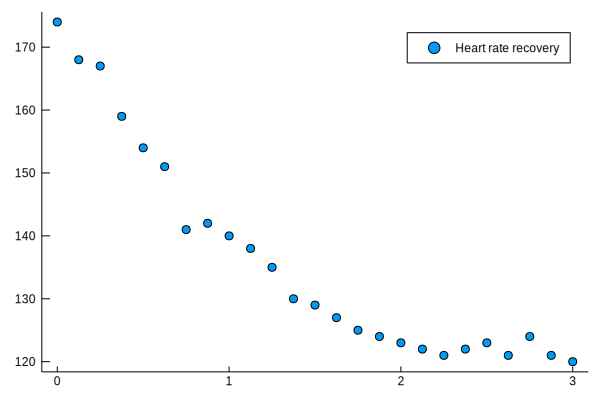

In [3]:
x =  [174.,168,167,159,154,151.,141,142, 140,138,135,130,129,127,125,124,123,122,121,122,123,121,124,121,120]
st = length(x)
ode_data = transpose(hcat(x[1:st]))
u0 = [x[1]]
tspan = (0.0f0, 3.f0)
t = range(tspan[1], tspan[2], length = st)
species1 = "Heart rate recovery"
scatter(t, ode_data[1,:], label = species1, grid = "off")

In [28]:
# Building a neural ODE 
# Derivative is modeled by a neural net. Chain concatinates the functions ode function and two dense layers.
dudt = Chain(Dense(1,100,tanh),
       Dense(100,100,tanh),
        Dense(100,100,tanh),
       Dense(100,1))
# Parameters of the model which are to be learnt. They are: W1 (2x50), b1 (50), W2 (50x2), b2 (2)
ps = Flux.params(dudt)
# Getting loss function from two stage collocation function
function node_two_stage_function(model, x, tspan, saveat, ode_data,
            args...; kwargs...)
  dudt_(du,u,p,t) = du .= model(u)
  prob_fly = ODEProblem(dudt_, x, tspan)
  two_stage_method(prob_fly, saveat, ode_data)
end
loss_n_ode = node_two_stage_function(dudt, u0, tspan, t, ode_data, Tsit5(), reltol = 1e-7, abstol = 1e-9)
#  loss function
two_stage_loss_fct()=loss_n_ode.cost_function(ps)
# Defining anonymous function for the neural ODE with the model. in: u0, out: solution with current params.
n_ode = x->neural_ode(dudt, x, tspan, Tsit5(), saveat = t, reltol = 1e-7, abstol = 1e-9)
# to be set by user:
n_epochs_collocation = 50000
n_epochs_L2 = 100
n_epochs = n_epochs_collocation+n_epochs_L2
verify = 1000 #every xth
data_collocation = Iterators.repeated((), n_epochs_collocation)
data_L2 = Iterators.repeated((), n_epochs_L2)
opt1 = ADAM(0.0001)
opt2 = ADAM(0.0001)
# Callback function to observe two stage training.
sa = saver(n_epochs)
L2_loss_fct() = sum(abs2, ode_data .- n_ode(u0))
cb1 = function ()
    sa.count_epochs = sa.count_epochs +  1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(two_stage_loss_fct()), Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        #println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(two_stage_loss_fct()), 0, Dates.Time(Dates.now()))
        #println("\"",Tracker.data(two_stage_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end
cb2 = function ()
    sa.count_epochs = sa.count_epochs + 1
    if mod(sa.count_epochs-1, verify)==0
        update_saver(sa, Tracker.data(L2_loss_fct()), Tracker.data(L2_loss_fct()), Dates.Time(Dates.now()))
        #println("\"",Tracker.data(L2_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    else
        update_saver(sa, Tracker.data(L2_loss_fct()), 0, Dates.Time(Dates.now()))
        #println("\"",Tracker.data(L2_loss_fct()),"\" \"",Dates.Time(Dates.now()),"\";")
    end
end

#17 (generic function with 1 method)

In [29]:
#two stage training call
@time Flux.train!(two_stage_loss_fct, ps, data_collocation, opt1, cb = cb1)
@time Flux.train!(L2_loss_fct, ps, data_L2, opt2, cb = cb2)

453.268213 seconds (639.77 M allocations: 142.739 GiB, 9.48% gc time)
5124.640298 seconds (2.64 G allocations: 3.978 TiB, 20.08% gc time)


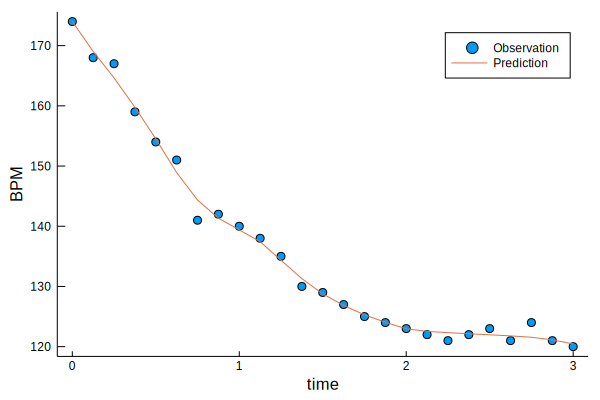

In [30]:
# Call n_ode to get first prediction and to show startpoint for training.
pred = n_ode(u0)
scatter(t, ode_data[1,:], label = "Observation", grid = "off", xlab = "time", ylab = "BPM")
plot!(t, Flux.data(pred[1,:]), label = "Prediction")

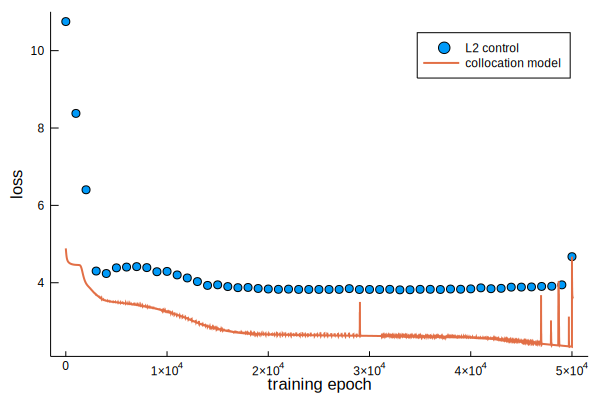

In [32]:
header = string("collocation model")
plot_l2 = replace!(sa.l2s, 0=>NaN)
scatter(range(1,stop=length(sa.l2s)),log.(plot_l2), label = "L2 control", grid = "off", ylab = "loss", xlab = "training epoch")
plot!(range(1,stop=length(sa.losses)),log.(sa.losses),width  =2, label = header)